In [196]:
from skimage.io import imread
from stardist.models import StarDist2D
from csbdeep.utils import Path, normalize
from skimage import morphology, measure
import os, glob, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from matplotlib import rc
rc('font', size=15)
rc('font', family='Arial')
# rc('font', serif='Times')
rc('pdf', fonttype=42)
# rc('text', usetex=True)


In [197]:
colors = ['black','blue','green','orange','maroon']
channels = ['Bright field','DAPI','Trim28','Sepdb1','Membrane']


In [198]:
imgFolder = os.path.join('..','2021-01-14_NMGstain_coated_and_uncoated','coated-wt-triton')
outputFolder = os.path.join('..','results_analysis','coated-wt-triton')

In [199]:
props = pd.read_csv(os.path.join(outputFolder,'props.csv'))
nch = len([i for i in props.keys() if 'mean_intens' in i])

# load image
imgName = glob.glob(os.path.join(imgFolder,'r6*.tif'))[0]
print(imgName)
X = imread(imgName)[8,]
print(X.shape)

# load image
imgName = glob.glob(os.path.join(outputFolder,'*.tif'))[0]
print(imgName)
Y = imread(imgName)
print(Y.shape)


..\2021-01-14_NMGstain_coated_and_uncoated\coated-wt-triton\r6c3.tif
(5, 2160, 2160)
..\results_analysis\coated-wt-triton\mask.tif
(2160, 2160)


In [200]:
props.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,min_intensity-0,min_intensity-1,min_intensity-2,min_intensity-3,min_intensity-4,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3,max_intensity-4
0,0,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,1,0,390,40,429,18.460639,408.686672,1283,...,2620,313,146,108,93,5692,1167,249,185,129
1,1,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,2,0,533,30,582,12.545844,558.868895,1167,...,3725,258,137,105,95,5235,853,241,198,125
2,2,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,3,0,778,41,825,20.557441,800.939948,1532,...,2801,252,140,109,98,5992,855,225,216,132
3,3,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,4,0,848,30,890,12.741396,867.653884,1017,...,2972,256,142,109,93,5327,930,233,184,134
4,4,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,5,0,1240,40,1295,17.400219,1266.723893,1829,...,2325,218,350,108,94,7868,938,4087,211,130


In [201]:
props.keys()

Index(['Unnamed: 0', 'fileName', 'label', 'bbox-0', 'bbox-1', 'bbox-2',
       'bbox-3', 'centroid-0', 'centroid-1', 'area', 'perimeter',
       'minor_axis_length', 'major_axis_length', 'eccentricity',
       'mean_intensity-0', 'mean_intensity-1', 'mean_intensity-2',
       'mean_intensity-3', 'mean_intensity-4', 'min_intensity-0',
       'min_intensity-1', 'min_intensity-2', 'min_intensity-3',
       'min_intensity-4', 'max_intensity-0', 'max_intensity-1',
       'max_intensity-2', 'max_intensity-3', 'max_intensity-4'],
      dtype='object')

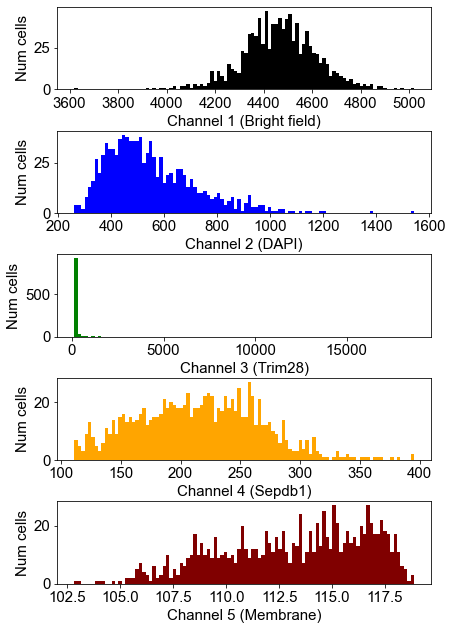

In [202]:
# plot of distributions
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6,9))
fig.subplots_adjust(top=0.99, hspace=0.5, bottom=0.1, right=0.99)
for i in range(nch):
    data = props['mean_intensity-%d'%i]
    ax[i].hist(data, bins=100, color=colors[i])
    ax[i].set_xlabel('Channel %d (%s)'%(i+1,channels[i]))
    ax[i].set_ylabel('Num cells')
plt.show()


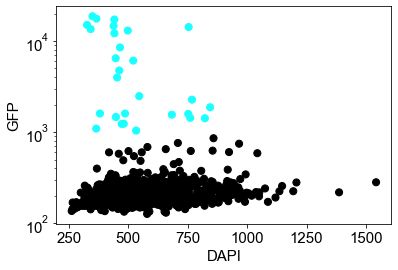

In [271]:
# determine cutoff to define cells that were successfully transfected
# use the gfp channel to determine threshold.
gfp = props['mean_intensity-%d'%2].values
dapi = props['mean_intensity-%d'%1].values

# Assume bimodal distribution (negative cells + positive cells) and use KMeans clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

# cluster the data points
kmeans.fit(np.log(gfp).reshape(-1,1))
y_kmeans = kmeans.predict(np.log(gfp).reshape(-1,1))

# visualize
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.0, 0.0, 0.0), (0,0,.5), (.2, .2, 1.), (.1,1.,1.)] # Experiment with this
cm = LinearSegmentedColormap.from_list('test', colors, N=255)

fig, ax = plt.subplots()
ax.scatter(dapi, gfp, c=y_kmeans, s=50, cmap=cm)
plt.yscale('log')
ax.set_xlabel('DAPI')
ax.set_ylabel('GFP')

# assign cluster to cells
props['transfected'] = y_kmeans.astype(bool)

In [272]:
transfected = props[props.transfected]
transfected.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,min_intensity-4,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3,max_intensity-4,transfected,corr_12,corr_13,corr_23
4,4,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,5,0,1240,40,1295,17.400219,1266.723893,1829,...,94,7868,938,4087,211,130,True,0.346385,0.332656,0.746021
196,196,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,197,330,645,374,687,351.354659,665.434631,1438,...,97,7065,643,19784,336,133,True,-0.215151,0.676569,0.170898
207,207,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,208,344,408,391,460,367.288164,434.280420,1808,...,99,6567,1109,3586,278,128,True,0.801247,0.787721,0.738317
219,219,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,220,364,1413,415,1456,388.574922,1433.667712,1595,...,100,6751,723,11992,304,134,True,0.134050,0.822730,0.332628
220,220,..\2021-01-14_NMGstain_coated_and_uncoated\coa...,221,367,698,410,742,386.930739,719.406332,1516,...,99,5934,605,30297,340,128,True,-0.431947,0.626968,0.032789


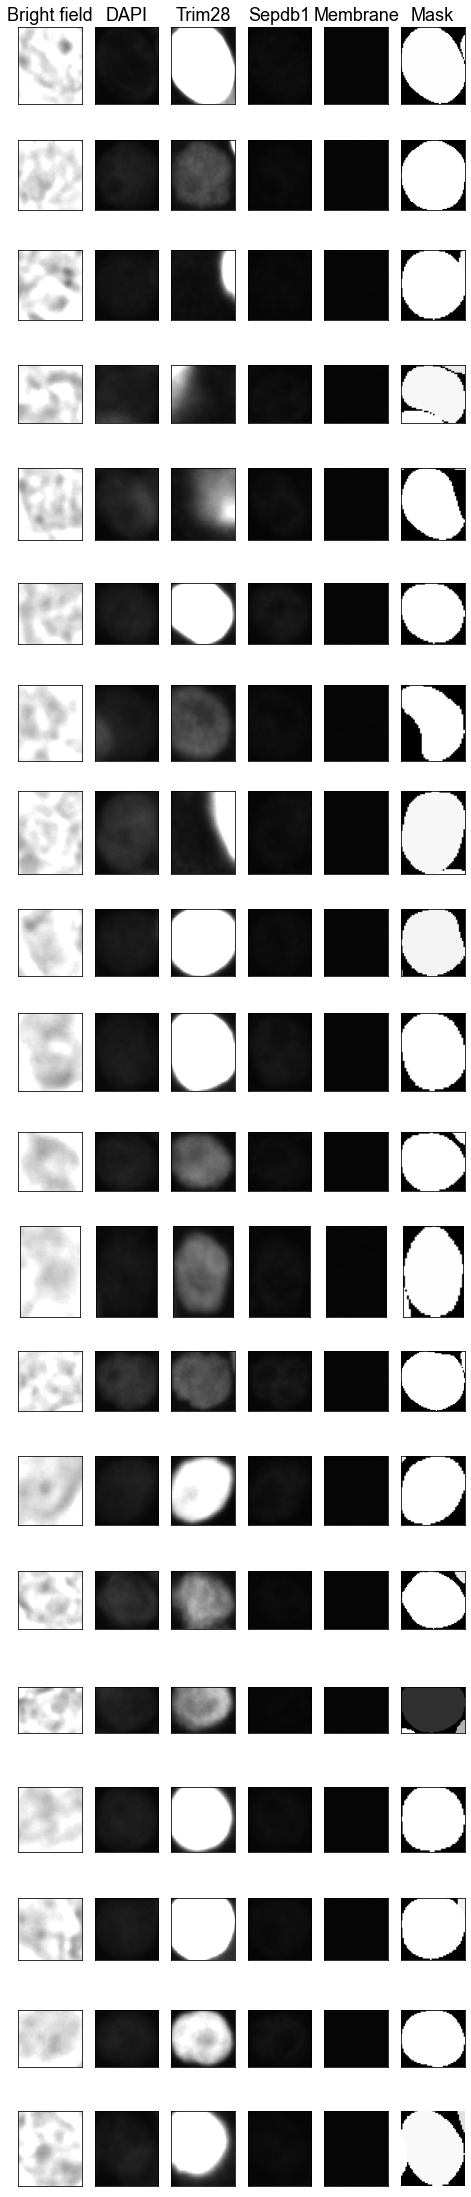

In [286]:
n_sample = 20
transfected_sample = transfected.sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,6,figsize=(8,2*n_sample))

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[:,int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    for j in range(5):
        ax[i,j].imshow(cell_img[j], cmap='gray',clim=(0,5000))
    ax[i,-1].imshow(cell_mask, cmap='gray')
    i+=1

for j in range(5):
    ax[0,j].set_title(channels[j])
    plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])


(1635,) (1635,) (1635,)
(1187,) (1187,) (1187,)
(1491,) (1491,) (1491,)
(1744,) (1744,) (1744,)
(2430,) (2430,) (2430,)


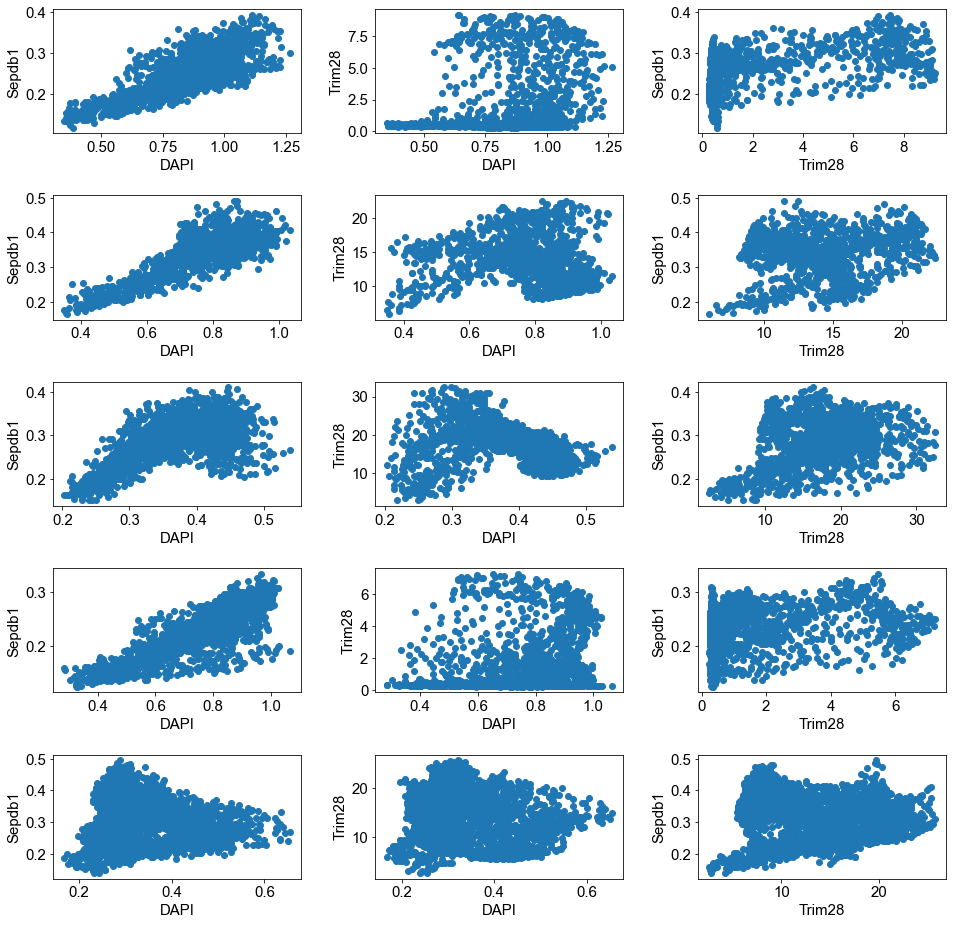

In [274]:
# for the sample, show correlation plots
fig,ax=plt.subplots(5,3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[:,int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    
    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==cell.label]/1000
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==cell.label]/1000
    
    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==cell.label]/1000
    
    print(dapi.shape, trim28.shape, sepdb1.shape)
    
    ax[i,0].scatter(dapi,sepdb1)
    ax[i,0].set_xlabel('DAPI')
    ax[i,0].set_ylabel('Sepdb1')

    ax[i,1].scatter(dapi,trim28)
    ax[i,1].set_xlabel('DAPI')
    ax[i,1].set_ylabel('Trim28')

    ax[i,2].scatter(trim28,sepdb1)
    ax[i,2].set_xlabel('Trim28')
    ax[i,2].set_ylabel('Sepdb1')
    
    i+=1


plt.show()


In [275]:
corr_12 = [np.nan for i in range(len(props))] # dapi-trim28
corr_13 = [np.nan for i in range(len(props))] # dapi-sepdb1
corr_23 = [np.nan for i in range(len(props))] # trim28-sepdb1

i=0
for idx, cell in props.iterrows():
    cell_img = X[:,int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==cell.label]/1000

    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==cell.label]/1000

    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==cell.label]/1000

    corr_12[i] = np.corrcoef(dapi,trim28)[0,1]
    corr_13[i] = np.corrcoef(dapi,sepdb1)[0,1]
    corr_23[i] = np.corrcoef(trim28,sepdb1)[0,1]
        
    i+=1

# append data to dataframe
props['corr_12'] = corr_12
props['corr_13'] = corr_13
props['corr_23'] = corr_23
    

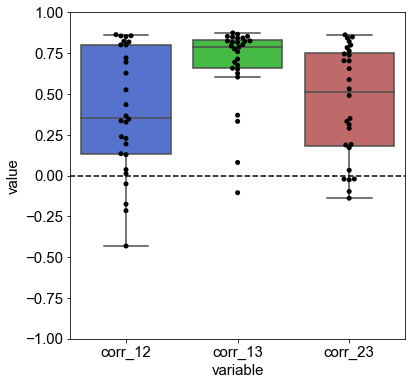

In [280]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected]
df = df[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=5, color='black')
ax.set_ylim(-1,1)
ax.plot([-1,4],[0,0],'--k')
plt.show()

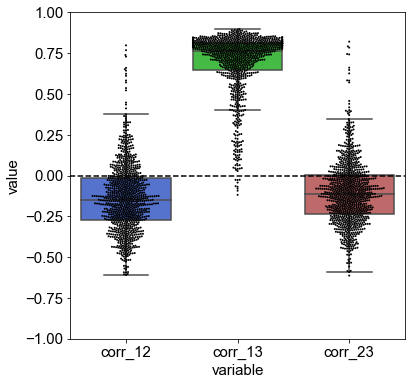

In [277]:
# for the sample, show correlation plots
import seaborn as sns
df1 = props[props.transfected==False]
df = df1[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=2, color='black')
ax.set_ylim(-1,1)
ax.plot([-1,4],[0,0],'--k')
plt.show()

(-1.0, 1.0)

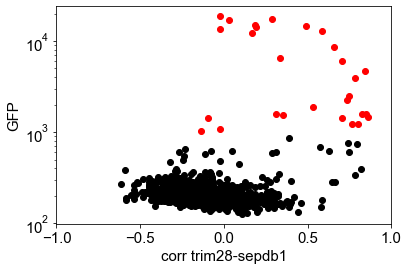

In [278]:
not_trasnfected = props[props.transfected==False]
plt.scatter(not_trasnfected['corr_23'],not_trasnfected['mean_intensity-2'],color='black')
trasnfected = props[props.transfected==True]
plt.scatter(trasnfected['corr_23'],trasnfected['mean_intensity-2'],color='red')
plt.xlabel('corr trim28-sepdb1')
plt.ylabel('GFP')
plt.yscale('log')
plt.xlim(-1,1)